# Parameters as the "Settings" of a Model

This notebook demonstrates a fundamental concept in prescriptive analytics: **parameters control how models see the world** and determine what they recommend.

Understanding this is critical because:
- Parameters are like "dials" or "settings" on a model
- Changing a parameter value changes the model's recommendation
- Different parameter sources have different levels of trustworthiness
- Wrong parameters lead to wrong recommendations, regardless of model quality


## Key Concepts

**Parameters** are the numbers that tell the model how the world works:
- Costs, capacities, processing times, demand levels, and more
- Think of them as "settings" or "dials" on a model
- When you change a parameter, the model behaves differently

**Parameter Sources** determine trustworthiness:
- **Historical data**: Generally more trustworthy (if data is good)
- **Forecasts**: Medium trust (predictions have uncertainty)
- **Expert estimates**: Lower trust (opinions, not facts)
- **Assumptions**: Lowest trust (may not reflect reality)

**Critical insight**: Parameters control the model's behavior. If parameters are wrong, the model sees the world incorrectly and gives wrong recommendations.


## Scenario: Production Planning Decision

You manage a factory that produces two products: Widget A and Widget B. You need to decide how many units of each to produce next month to maximize profit.

**The model needs these parameters:**
- Profit per unit of Widget A (from accounting data)
- Profit per unit of Widget B (from accounting data)
- Demand forecast for Widget A (from predictive model)
- Demand forecast for Widget B (from predictive model)
- Production capacity (from facility constraints)
- Labor hours available (from workforce planning)

**Key question**: What happens when these parameters change? How does that affect the recommendation?


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value


## Step 3: Scenario 1 - Base Case Parameters

Let's start with a base case using specific parameter values. Notice where each parameter comes from and how trustworthy it is:


In [3]:
# PARAMETERS: These are the "settings" that control the model
# Each parameter comes from a different source with different trust levels

# Profit per unit (from accounting data - HIGH TRUST)
profit_A = 50  # $ per unit of Widget A
profit_B = 40  # $ per unit of Widget B

# Demand forecasts (from predictive model - MEDIUM TRUST)
demand_A = 1000  # Forecasted demand for Widget A
demand_B = 800   # Forecasted demand for Widget B

# Capacity constraints (from facility - HIGH TRUST)
capacity = 2000   # Total production capacity (units)
labor_hours = 1500  # Available labor hours
labor_per_A = 0.5  # Labor hours per Widget A
labor_per_B = 0.8  # Labor hours per Widget B

print("PARAMETERS (Model Settings):")
print(f"  Profit A: ${profit_A} (from accounting data - HIGH TRUST)")
print(f"  Profit B: ${profit_B} (from accounting data - HIGH TRUST)")
print(f"  Demand A: {demand_A} units (from forecast - MEDIUM TRUST)")
print(f"  Demand B: {demand_B} units (from forecast - MEDIUM TRUST)")
print(f"  Capacity: {capacity} units (from facility - HIGH TRUST)")
print(f"  Labor: {labor_hours} hours (from workforce - HIGH TRUST)")


PARAMETERS (Model Settings):
  Profit A: $50 (from accounting data - HIGH TRUST)
  Profit B: $40 (from accounting data - HIGH TRUST)
  Demand A: 1000 units (from forecast - MEDIUM TRUST)
  Demand B: 800 units (from forecast - MEDIUM TRUST)
  Capacity: 2000 units (from facility - HIGH TRUST)
  Labor: 1500 hours (from workforce - HIGH TRUST)


## Step 4: Build and Solve Model with Base Parameters

Now let's build the optimization model using these parameters:


In [4]:
# Create the optimization model
model1 = LpProblem("Production_Planning_Base", LpMaximize)

# Decision variables (what we control)
produce_A = LpVariable("Produce_A", lowBound=0, cat='Continuous')
produce_B = LpVariable("Produce_B", lowBound=0, cat='Continuous')

# Objective: Maximize profit (using profit parameters)
model1 += profit_A * produce_A + profit_B * produce_B, "Total_Profit"

# Constraints (using capacity and demand parameters)
model1 += produce_A + produce_B <= capacity, "Capacity_Constraint"
model1 += labor_per_A * produce_A + labor_per_B * produce_B <= labor_hours, "Labor_Constraint"
model1 += produce_A <= demand_A, "Demand_A_Constraint"
model1 += produce_B <= demand_B, "Demand_B_Constraint"

# Solve the model
model1.solve()

# Get results
solution_A1 = value(produce_A)
solution_B1 = value(produce_B)
profit1 = value(model1.objective)

print("SCENARIO 1 RESULTS (Base Parameters):")
print(f"  Produce {solution_A1:.0f} units of Widget A")
print(f"  Produce {solution_B1:.0f} units of Widget B")
print(f"  Total Profit: ${profit1:,.0f}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/34507c59fb00444cb792a420c5ed1025-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/34507c59fb00444cb792a420c5ed1025-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 18 RHS
At line 23 BOUNDS
At line 24 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-4) rows, 0 (-2) columns and 0 (-6) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 82000
After Postsolve, objective 82000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 82000 - 0 iterations time 0.002, Presolve 0.00
Option for 

## Step 5: Change Parameters - See How Recommendations Change

Now let's change one parameter and see how the recommendation changes. This demonstrates that **parameters control the model's behavior**:


In [5]:
# SCENARIO 2: Change the profit parameter for Widget A
# What if the profit per unit of Widget A is actually $60 instead of $50?
# (Maybe accounting data was wrong, or market conditions changed)

profit_A_new = 60  # Changed parameter

print("PARAMETER CHANGE:")
print(f"  Old Profit A: ${profit_A}")
print(f"  New Profit A: ${profit_A_new}")
print("\nThis is like turning a dial on the model - it will behave differently!")

# Create new model with changed parameter
model2 = LpProblem("Production_Planning_Changed", LpMaximize)

# Same decision variables
produce_A2 = LpVariable("Produce_A", lowBound=0, cat='Continuous')
produce_B2 = LpVariable("Produce_B", lowBound=0, cat='Continuous')

# Objective with NEW parameter
model2 += profit_A_new * produce_A2 + profit_B * produce_B2, "Total_Profit"

# Same constraints
model2 += produce_A2 + produce_B2 <= capacity, "Capacity_Constraint"
model2 += labor_per_A * produce_A2 + labor_per_B * produce_B2 <= labor_hours, "Labor_Constraint"
model2 += produce_A2 <= demand_A, "Demand_A_Constraint"
model2 += produce_B2 <= demand_B, "Demand_B_Constraint"

# Solve
model2.solve()

# Get results
solution_A2 = value(produce_A2)
solution_B2 = value(produce_B2)
profit2 = value(model2.objective)

print("\nSCENARIO 2 RESULTS (Changed Parameter):")
print(f"  Produce {solution_A2:.0f} units of Widget A")
print(f"  Produce {solution_B2:.0f} units of Widget B")
print(f"  Total Profit: ${profit2:,.0f}")


PARAMETER CHANGE:
  Old Profit A: $50
  New Profit A: $60

This is like turning a dial on the model - it will behave differently!
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/aa2088412016481d9f85f2f9df18ed41-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/aa2088412016481d9f85f2f9df18ed41-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 18 RHS
At line 23 BOUNDS
At line 24 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-4) rows, 0 (-2) columns and 0 (-6) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 92000
After Postsolve, object

## Step 6: Visualize How Parameters Control Recommendations

Let's visualize how changing parameters changes recommendations:


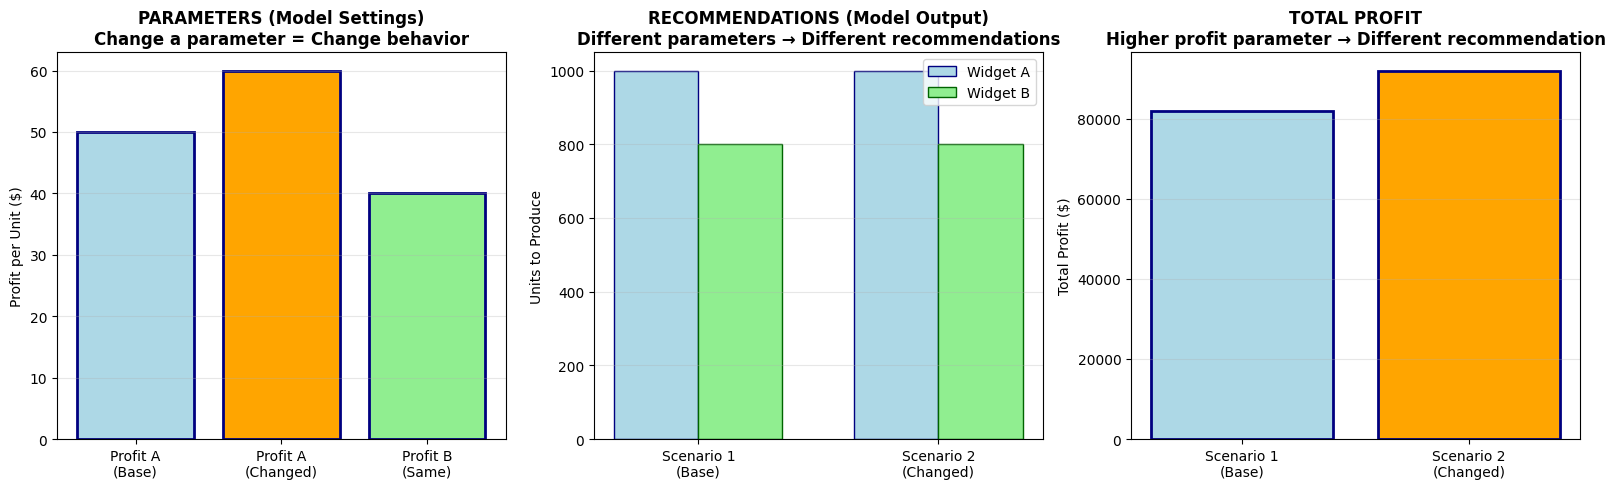


KEY INSIGHT:
  - Changed ONE parameter (Profit A: $50 → $60)
  - Model recommendation CHANGED (different production mix)
  - This shows: Parameters control the model's behavior!
  - If parameters are wrong, recommendations will be wrong too!


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Parameter values
ax1 = axes[0]
params = ['Profit A\n(Base)', 'Profit A\n(Changed)', 'Profit B\n(Same)']
values = [profit_A, profit_A_new, profit_B]
colors = ['lightblue', 'orange', 'lightgreen']
ax1.bar(params, values, color=colors, edgecolor='navy', linewidth=2)
ax1.set_title('PARAMETERS (Model Settings)\nChange a parameter = Change behavior', 
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Profit per Unit ($)')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Production recommendations
ax2 = axes[1]
scenarios = ['Scenario 1\n(Base)', 'Scenario 2\n(Changed)']
widget_A = [solution_A1, solution_A2]
widget_B = [solution_B1, solution_B2]
x = np.arange(len(scenarios))
width = 0.35
ax2.bar(x - width/2, widget_A, width, label='Widget A', color='lightblue', edgecolor='navy')
ax2.bar(x + width/2, widget_B, width, label='Widget B', color='lightgreen', edgecolor='darkgreen')
ax2.set_title('RECOMMENDATIONS (Model Output)\nDifferent parameters → Different recommendations', 
              fontsize=12, fontweight='bold')
ax2.set_ylabel('Units to Produce')
ax2.set_xticks(x)
ax2.set_xticklabels(scenarios)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Total profit
ax3 = axes[2]
profits = [profit1, profit2]
ax3.bar(scenarios, profits, color=['lightblue', 'orange'], edgecolor='navy', linewidth=2)
ax3.set_title('TOTAL PROFIT\nHigher profit parameter → Different recommendation', 
              fontsize=12, fontweight='bold')
ax3.set_ylabel('Total Profit ($)')
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT:")
print("  - Changed ONE parameter (Profit A: $50 → $60)")
print("  - Model recommendation CHANGED (different production mix)")
print("  - This shows: Parameters control the model's behavior!")
print("  - If parameters are wrong, recommendations will be wrong too!")


## Step 7: Test Multiple Parameter Changes

Let's see what happens when we change different parameters. This demonstrates that **every parameter matters**:


In [7]:
# Test different parameter scenarios
scenarios = {
    'Base': {'profit_A': 50, 'profit_B': 40, 'demand_A': 1000, 'demand_B': 800},
    'Higher Demand A': {'profit_A': 50, 'profit_B': 40, 'demand_A': 1500, 'demand_B': 800},
    'Higher Profit B': {'profit_A': 50, 'profit_B': 50, 'demand_A': 1000, 'demand_B': 800},
    'Lower Capacity': {'profit_A': 50, 'profit_B': 40, 'demand_A': 1000, 'demand_B': 800, 'capacity': 1500}
}

results = []

for name, params in scenarios.items():
    # Create model
    model = LpProblem(f"Scenario_{name}", LpMaximize)
    prod_A = LpVariable("Produce_A", lowBound=0, cat='Continuous')
    prod_B = LpVariable("Produce_B", lowBound=0, cat='Continuous')
    
    # Objective
    model += params['profit_A'] * prod_A + params['profit_B'] * prod_B, "Total_Profit"
    
    # Constraints
    cap = params.get('capacity', capacity)
    model += prod_A + prod_B <= cap, "Capacity"
    model += labor_per_A * prod_A + labor_per_B * prod_B <= labor_hours, "Labor"
    model += prod_A <= params['demand_A'], "Demand_A"
    model += prod_B <= params['demand_B'], "Demand_B"
    
    # Solve
    model.solve()
    
    results.append({
        'Scenario': name,
        'Produce A': value(prod_A),
        'Produce B': value(prod_B),
        'Profit': value(model.objective),
        'Changed Param': list(params.keys())[0] if name != 'Base' else 'None'
    })

# Display results
results_df = pd.DataFrame(results)
print("COMPARISON: Different Parameters → Different Recommendations\n")
print(results_df.to_string(index=False))

print("\n\nOBSERVATION:")
print("  Each parameter change leads to a different recommendation.")
print("  This proves: Parameters are like 'settings' that control the model!")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/3cfeb9a62ba241cfb98b8287d8800395-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/3cfeb9a62ba241cfb98b8287d8800395-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 18 RHS
At line 23 BOUNDS
At line 24 ENDATA
Problem MODEL has 4 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-4) rows, 0 (-2) columns and 0 (-6) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 82000
After Postsolve, objective 82000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 82000 - 0 iterations time 0.002, Presolve 0.00
Option for 

/Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


## Step 8: Parameter Sources and Trust Levels

Different parameter sources have different levels of trustworthiness. Let's see how this affects our confidence in recommendations:


PARAMETER SOURCES AND TRUST LEVELS:

  Parameter          Source Trust Level  Value
   Profit A Accounting Data        High     50
   Profit B Accounting Data        High     40
   Demand A        Forecast      Medium   1000
   Demand B        Forecast      Medium    800
   Capacity        Facility        High   2000
Labor Hours  Workforce Plan        High   1500


KEY INSIGHT:
  - Parameters from reliable data (accounting, facility) = HIGH TRUST
  - Parameters from forecasts = MEDIUM TRUST (uncertainty exists)
  - If key parameters have LOW TRUST, recommendations have HIGH RISK
  - Always know where your parameters come from!


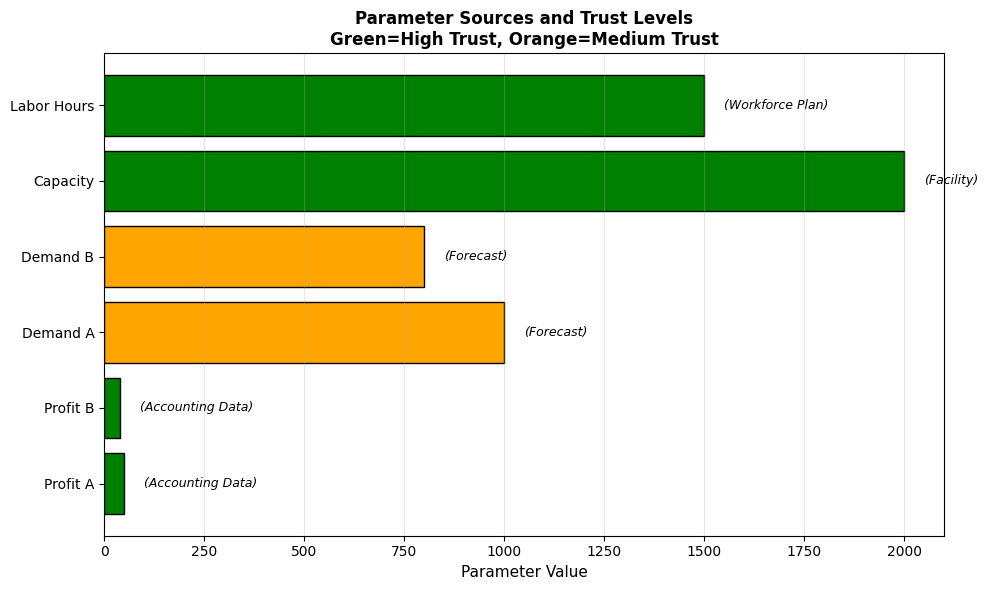

In [8]:
# Parameter sources and trust levels
parameter_sources = pd.DataFrame({
    'Parameter': ['Profit A', 'Profit B', 'Demand A', 'Demand B', 'Capacity', 'Labor Hours'],
    'Source': ['Accounting Data', 'Accounting Data', 'Forecast', 'Forecast', 'Facility', 'Workforce Plan'],
    'Trust Level': ['High', 'High', 'Medium', 'Medium', 'High', 'High'],
    'Value': [profit_A, profit_B, demand_A, demand_B, capacity, labor_hours]
})

print("PARAMETER SOURCES AND TRUST LEVELS:\n")
print(parameter_sources.to_string(index=False))

print("\n\nKEY INSIGHT:")
print("  - Parameters from reliable data (accounting, facility) = HIGH TRUST")
print("  - Parameters from forecasts = MEDIUM TRUST (uncertainty exists)")
print("  - If key parameters have LOW TRUST, recommendations have HIGH RISK")
print("  - Always know where your parameters come from!")

# Visualize trust levels
fig, ax = plt.subplots(figsize=(10, 6))
trust_colors = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}
colors = [trust_colors.get(level, 'gray') for level in parameter_sources['Trust Level']]

bars = ax.barh(parameter_sources['Parameter'], parameter_sources['Value'], color=colors, edgecolor='black')
ax.set_xlabel('Parameter Value', fontsize=11)
ax.set_title('Parameter Sources and Trust Levels\nGreen=High Trust, Orange=Medium Trust', 
              fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add source labels
for i, (bar, source) in enumerate(zip(bars, parameter_sources['Source'])):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
            f"({source})", va='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()


## Summary: Parameters as Model Settings

**Key Takeaways:**

1. **Parameters are like "settings" or "dials" on a model**
   - Changing a parameter changes the model's recommendation
   - Parameters control how the model sees the world

2. **Parameter sources matter**
   - Historical data: Generally more trustworthy
   - Forecasts: Medium trust (have uncertainty)
   - Expert estimates: Lower trust
   - Assumptions: Lowest trust

3. **Wrong parameters = Wrong recommendations**
   - Even perfect optimization logic gives wrong answers if parameters are wrong
   - Always verify parameter sources and trust levels

4. **Practical implications**
   - Track where each parameter comes from
   - Understand the trust level for each parameter
   - Be cautious when key parameters have low trust
   - Test what happens if parameters are wrong (sensitivity analysis)

**Remember**: Models are only as good as their parameters. Parameters are estimates, not facts!
